In [1]:
from utils import tone_generator
import numpy as np
from fastICA import fastICA
import matplotlib.pyplot as plt

Let's generate 3 pure tone waves at 440 Hz, 784 Hz, 1500 Hz

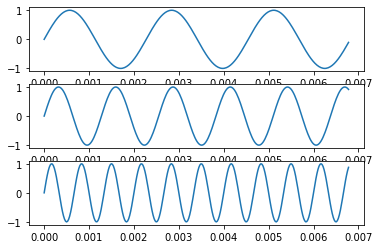

In [2]:
fs = 44100
duration = 1 # in seconds
tone_440 = tone_generator(duration, 440, fs)
tone_784 = tone_generator(duration, 784, fs)
tone_1500 = tone_generator(duration, 1500, fs)
ts = np.linspace(0, duration, duration*fs)

fig, axs = plt.subplots(3)
axs[0].plot(ts[:300], tone_440[:300])
axs[1].plot(ts[:300], tone_784[:300])
axs[2].plot(ts[:300], tone_1500[:300])

In the frequency domain, we have:

Text(0.5, 0.98, 'PSD of pure tone waves')

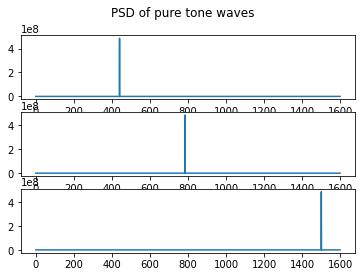

In [3]:
from scipy import fftpack
tone_440_fft = fftpack.fft(tone_440)
psd_440 = np.abs(tone_440_fft)**2
tone_784_fft = fftpack.fft(tone_784)
psd_784 = np.abs(tone_784_fft)**2
tone_1500_fft = fftpack.fft(tone_1500)
psd_1500 = np.abs(tone_1500_fft)**2
freqs = fftpack.fftfreq(tone_440.size, d=1/fs)

fig, axs = plt.subplots(3)
axs[0].plot(freqs[:1600], psd_440[:1600])
axs[1].plot(freqs[:1600], psd_784[:1600])
axs[2].plot(freqs[:1600], psd_1500[:1600])
fig.suptitle('PSD of pure tone waves')

Now, we mix the signals to create 3 mixes (3 microphones or sensors).

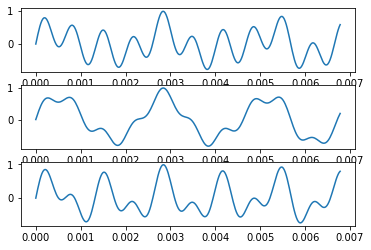

In [4]:
observed_1 = 0.3 * tone_440 + 0.2 * tone_784 + 0.5 * tone_1500
observed_2 = 0.7 * tone_440 + 0.1 * tone_784 + 0.2 * tone_1500
observed_3 = 0.1 * tone_440 + 0.5 * tone_784 + 0.4 * tone_1500
fig, axs = plt.subplots(3)
axs[0].plot(ts[:300], observed_1[:300])
axs[1].plot(ts[:300], observed_2[:300])
axs[2].plot(ts[:300], observed_3[:300])

# ICA and Blind Source Separation
We suppose the above 3 signals are the observed signals. They are mixes of 3 independent signals. Blind source separation is the task of retrieving these 3 independent signals. In practice we might not now how many independent signals are mixed, so it is a hyperparameter. Also, you need at least as many observed signals as the number of independent signals you can recover. For example you might have a bunch of sensors measuring the same phenomenon, with at least as many sensors as you think there are independent ground truthes.

In the case of the gravitational wave problem, we have 3 interferometers: 1 in Italy, 2 in the US, and we can assume 2 independent signals, namely, noise and blackhole collision.

I think there are variations that relax this restriction, but I haven't looked into them. Also, it seems it can also be run on images, I am not sure how would that work in terms of the # of observed signals vs # of independent components relationship.

In [5]:
#stack signals, as many rows as observed signals (sensors), as many columns as samples
X = np.column_stack((observed_1, observed_2, observed_3))
C = 3 #number of independent components that we believe are in the recorded signals
fICA = fastICA(C)
S = fICA.separate(X)

Let's plot the recovered independent signals and their PSD:

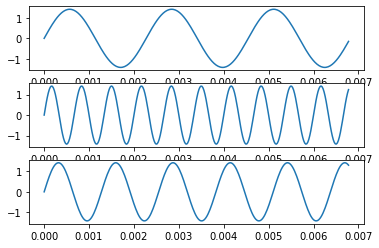

In [6]:
fig, axs = plt.subplots(3)
axs[0].plot(ts[:300], S[0][:300])
axs[1].plot(ts[:300], S[1][:300])
axs[2].plot(ts[:300], S[2][:300])

Text(0.5, 0.98, 'PSD of recovered signals')

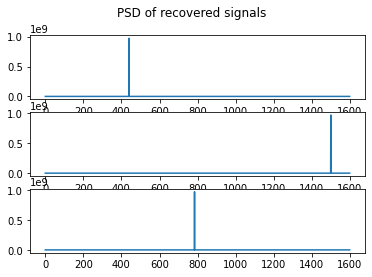

In [7]:
recovered_1_fft = fftpack.fft(S[0])
psd_recovered_1 = np.abs(recovered_1_fft)**2
recovered_2_fft = fftpack.fft(S[1])
psd_recovered_2 = np.abs(recovered_2_fft)**2
recovered_3_fft = fftpack.fft(S[2])
psd_recovered_3 = np.abs(recovered_3_fft)**2
freqs = fftpack.fftfreq(S[0].size, d=1/fs)

fig, axs = plt.subplots(3)
axs[0].plot(freqs[:1600], psd_recovered_1[:1600])
axs[1].plot(freqs[:1600], psd_recovered_2[:1600])
axs[2].plot(freqs[:1600], psd_recovered_3[:1600])
fig.suptitle('PSD of recovered signals')

# Mix of music and voice
Let's now consider two recordings of someone playing guitar and someone speaking over him.

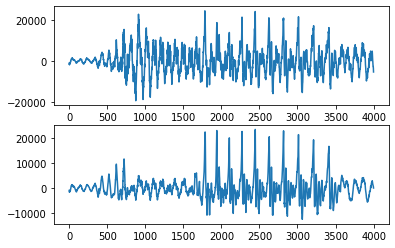

In [8]:
import IPython.display as ipd
import scipy.io.wavfile
ipd.display(ipd.Audio('demos/mix1.wav'))
ipd.display(ipd.Audio('demos/mix2.wav'))
fs, mix1 = scipy.io.wavfile.read('demos/mix1.wav')
fs, mix2 = scipy.io.wavfile.read('demos/mix2.wav')
fig, axs = plt.subplots(2)
axs[0].plot(mix1[:4000])
axs[1].plot(mix2[:4000])

In [9]:
X = np.column_stack((mix1, mix2))
C = 2
fICA = fastICA(C)
S = fICA.separate(X)

After running ICA, let's listen to the generated independent components:

In [10]:
ipd.display(ipd.Audio(S[0], rate=fs))
ipd.display(ipd.Audio(S[1], rate=fs))

The algorithm seems to have recognized that there are 2 independent components: the voice and the guitar. However, in the voice component, we can still hear the guitar in the back, although at a low volume.